<a href="https://colab.research.google.com/github/nimamt/machine_learning/blob/master/pytorch/reinforcement/VanillaPolicyGradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Inspired by OpenAI Spinning Up PPO implementation.

The picture is from:
https://danieltakeshi.github.io/2018/06/28/a2c-a3c/

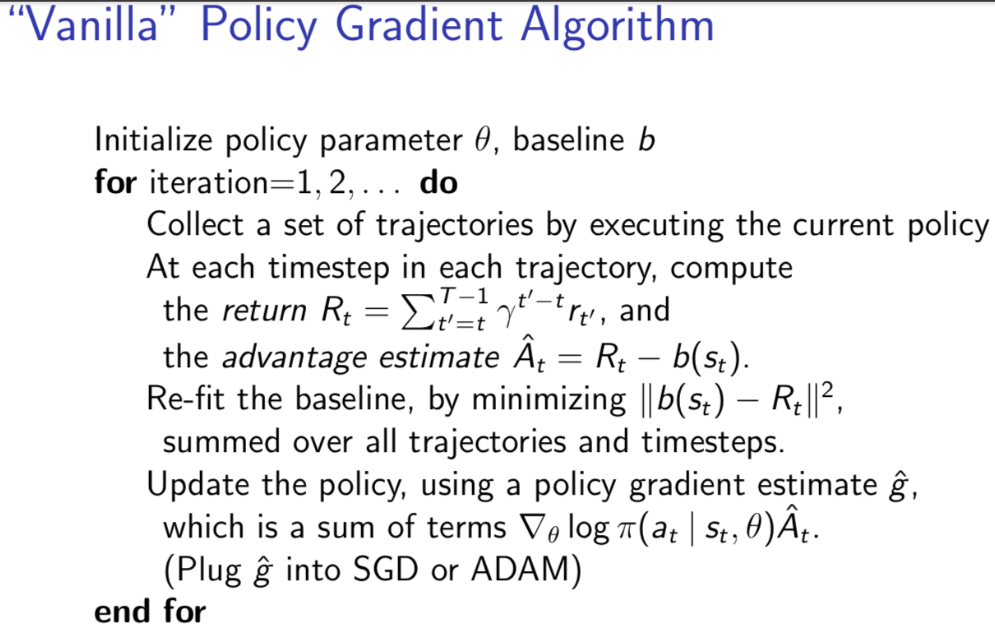

In [1]:
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 KB 24.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 48.6 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
  Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. Discussion can be found at https:

In [61]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical, Normal
from torch.utils.data import DataLoader
from collections import deque
import scipy.signal
from gym.spaces import Box, Discrete
from torch.optim import Adam

def combined_shape(length, shape=None):
    if shape is None:
        return (length,)
    return (length, shape) if np.isscalar(shape) else (length, *shape)

def mlp(sizes, activation, output_activation=nn.Identity):
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)

class Actor(nn.Module):

    def _distribution(self, obs):
        raise NotImplementedError

    def _log_prob_from_distribution(self, pi, act):
        raise NotImplementedError

    def forward(self, obs, act=None):
        # Produce action distributions for given observations, and 
        # optionally compute the log likelihood of given actions under
        # those distributions.
        pi = self._distribution(obs)
        logp_a = None
        if act is not None:
            logp_a = self._log_prob_from_distribution(pi, act)
        return pi, logp_a

class MLPCategoricalActor(Actor):
    
    def __init__(self, obs_dim, act_dim, hidden_sizes, activation):
        super().__init__()
        self.logits_net = mlp([obs_dim] + list(hidden_sizes) + [act_dim], activation)

    def _distribution(self, obs):
        logits = self.logits_net(obs)
        return Categorical(logits=logits)

    def _log_prob_from_distribution(self, pi, act):
        return pi.log_prob(act)


class MLPGaussianActor(Actor):

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation):
        super().__init__()
        log_std = -0.5 * np.ones(act_dim, dtype=np.float32)
        self.log_std = torch.nn.Parameter(torch.as_tensor(log_std))
        self.mu_net = mlp([obs_dim] + list(hidden_sizes) + [act_dim], activation)

    def _distribution(self, obs):
        mu = self.mu_net(obs)
        std = torch.exp(self.log_std)
        return Normal(mu, std)

    def _log_prob_from_distribution(self, pi, act):
        return pi.log_prob(act).sum(axis=-1)    # Last axis sum needed for Torch Normal distribution

class MLPCritic(nn.Module):

    def __init__(self, obs_dim, hidden_sizes, activation):
        super().__init__()
        self.v_net = mlp([obs_dim] + list(hidden_sizes) + [1], activation)

    def forward(self, obs):
        return torch.squeeze(self.v_net(obs), -1) # Critical to ensure v has right shape.

class MLPActorCritic(nn.Module):
    def __init__(self, observation_space, action_space, 
                 hidden_sizes=(256,128), activation=nn.Tanh):
        super().__init__()

        obs_dim = observation_space.shape[0]

        # policy builder depends on action space
        if isinstance(action_space, Box):
            self.pi = MLPGaussianActor(obs_dim, action_space.shape[0], hidden_sizes, activation)
        elif isinstance(action_space, Discrete):
            self.pi = MLPCategoricalActor(obs_dim, action_space.n, hidden_sizes, activation)

        # build value function
        self.v  = MLPCritic(obs_dim, hidden_sizes, activation)

    def step(self, obs):
        with torch.no_grad():
            pi = self.pi._distribution(obs)
            a = pi.sample()
            logp_a = self.pi._log_prob_from_distribution(pi, a)
            v = self.v(obs)
        return a.numpy(), v.numpy(), logp_a.numpy()

    def act(self, obs):
        return self.step(obs)[0]

def discount_cumsum(x, discount):
    """
    magic from rllab for computing discounted cumulative sums of vectors.
    input: 
        vector x, 
        [x0, 
         x1, 
         x2]
    output:
        [x0 + discount * x1 + discount^2 * x2,  
         x1 + discount * x2,
         x2]
    """
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]

class VPGBuffer:
    def __init__(self, obs_dim, act_dim, size, gamma=0.99):
        self.obs_buf = np.zeros(combined_shape(size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros(combined_shape(size, act_dim), dtype=np.float32)
        self.adv_buf = np.zeros(size, dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.ret_buf = np.zeros(size, dtype=np.float32)
        self.val_buf = np.zeros(size, dtype=np.float32)
        self.logp_buf = np.zeros(size, dtype=np.float32)
        self.gamma = gamma
        self.ptr, self.path_start_idx, self.max_size = 0, 0, size

    def store(self, obs, act, rew, val, logp):
        assert self.ptr < self.max_size     # buffer has to have room so you can store
        self.obs_buf[self.ptr] = obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.val_buf[self.ptr] = val
        self.logp_buf[self.ptr] = logp
        self.ptr += 1

    def finish_path(self, last_val=0):
        path_slice = slice(self.path_start_idx, self.ptr)
        rews = np.append(self.rew_buf[path_slice], last_val)
        vals = np.append(self.val_buf[path_slice], last_val)
        
        # the next two lines implement GAE-Lambda advantage calculation
        deltas = rews[:-1] + self.gamma * vals[1:] - vals[:-1]
        
        # the next line computes rewards-to-go, to be targets for the value function
        self.ret_buf[path_slice] = discount_cumsum(rews, self.gamma)[:-1]
        self.adv_buf[path_slice] = self.ret_buf[path_slice] - vals[:-1]
        
        self.path_start_idx = self.ptr

    def get(self):
        self.ptr, self.path_start_idx = 0, 0
        # the next two lines implement the advantage normalization trick
        adv_mean, adv_std = np.mean(self.adv_buf), np.std(self.adv_buf)
        self.adv_buf = (self.adv_buf - adv_mean) / adv_std

        data = dict(obs=self.obs_buf, act=self.act_buf, ret=self.ret_buf,
                    adv=self.adv_buf, logp=self.logp_buf)
        return {k: torch.as_tensor(v, dtype=torch.float32) for k,v in data.items()}

In [62]:
def vpg(env_fn, actor_critic=MLPActorCritic, ac_kwargs=dict(), seed=0, 
        steps_per_epoch=4000, epochs=30, gamma=0.99, clip_ratio=0.2, pi_lr=3e-4,
        vf_lr=1e-3, train_pi_iters=80, train_v_iters=80, lam=0.97, max_ep_len=1000,
        target_kl=0.01):
    
    env = env_fn()
    obs_dim = env.observation_space.shape
    act_dim = env.action_space.shape

    ac = actor_critic(env.observation_space, env.action_space)
    buffer = VPGBuffer(obs_dim, act_dim, steps_per_epoch, gamma)

    # Set up function for computing PPO policy loss
    def compute_loss_pi(data):
        obs, act, adv, logp_old = data['obs'], data['act'], data['adv'], data['logp']

        # Policy loss
        pi, logp = ac.pi(obs, act)
        ratio = logp
        loss_pi = -(ratio * adv).sum()

        # Useful extra info
        approx_kl = (logp_old - logp).mean()
        ent = pi.entropy().mean().item()
        clipped = ratio.gt(1+clip_ratio) | ratio.lt(1-clip_ratio)
        clipfrac = torch.as_tensor(clipped, dtype=torch.float32).mean().item()
        pi_info = dict(kl=approx_kl, ent=ent, cf=clipfrac)

        return loss_pi, pi_info

    # Set up function for computing value loss
    def compute_loss_v(data):
        obs, ret = data['obs'], data['ret']
        return ((ac.v(obs) - ret)**2).mean()

    # Set up optimizers for policy and value function
    pi_optimizer = Adam(ac.pi.parameters(), lr=pi_lr)
    vf_optimizer = Adam(ac.v.parameters(), lr=vf_lr)

    def update():
        data = buffer.get()

        pi_l_old, pi_info_old = compute_loss_pi(data)
        pi_l_old = pi_l_old.item()
        v_l_old = compute_loss_v(data).item()

        # Train policy with multiple steps of gradient descent
        for i in range(train_pi_iters):
            pi_optimizer.zero_grad()
            loss_pi, pi_info = compute_loss_pi(data)
            kl = torch.mean(pi_info['kl'])
            if kl > 1.5 * target_kl:
                # logger.log('Early stopping at step %d due to reaching max kl.'%i)
                break
            loss_pi.backward()
            # mpi_avg_grads(ac.pi)    # average grads across MPI processes
            pi_optimizer.step()

        # Value function learning
        for i in range(train_v_iters):
            vf_optimizer.zero_grad()
            loss_v = compute_loss_v(data)
            loss_v.backward()
            # mpi_avg_grads(ac.v)    # average grads across MPI processes
            vf_optimizer.step()
            
    # Prepare for interaction with environment
    o, ep_ret, ep_len = env.reset(), 0, 0
    score = 0

    # Main loop: collect experience in env and update/log each epoch
    for epoch in range(epochs):
        scores = np.array([])
        for t in range(steps_per_epoch):
            a, v, logp = ac.step(torch.as_tensor(o, dtype=torch.float32))

            next_o, r, d, _ = env.step(a)
            ep_ret += r
            ep_len += 1

            # save
            buffer.store(o, a, r, v, logp)
            
            # Update obs (critical!)
            o = next_o

            timeout = ep_len == max_ep_len
            terminal = d or timeout
            epoch_ended = t==steps_per_epoch-1

            if terminal or epoch_ended:
                if epoch_ended and not(terminal):
                    print('Warning: trajectory cut off by epoch at %d steps.'%t, flush=True)
                # if trajectory didn't reach terminal state, bootstrap value target
                if epoch_ended:
                    _, v, _ = ac.step(torch.as_tensor(o, dtype=torch.float32))
                else:
                    v = 0
                buffer.finish_path(v)
                if d:
                    scores = np.append(scores, ep_ret)
                o, ep_ret, ep_len = env.reset(), 0, 0
        print(f"Episode {epoch} Score: {scores.mean()}")
        update()
        buffer = VPGBuffer(obs_dim, act_dim, steps_per_epoch, gamma)

In [63]:
vpg(lambda : gym.make("LunarLanderContinuous-v2"))

Episode 0 Score: -170.30811571357913
Episode 1 Score: -200.95802093841607
Episode 2 Score: -139.49871778826298
Episode 3 Score: -111.49675141111064
Episode 4 Score: -142.9853693768777
Episode 5 Score: -128.65567050165757
Episode 6 Score: -100.22813234606376
Episode 7 Score: -79.14788566479288
Episode 8 Score: -51.090801836027524
Episode 9 Score: -31.790022584010835
Episode 10 Score: -21.09191533558016
Episode 11 Score: 2.4026194411864066
Episode 12 Score: -69.98349907627389
Episode 13 Score: -109.90836646364289
Episode 14 Score: -200.7898748044385
Episode 15 Score: -101.75252652259651
Episode 16 Score: -51.779117959496816
Episode 17 Score: -89.28827149251339
Episode 18 Score: -78.37571147560817
Episode 19 Score: -23.876849892615464
Episode 20 Score: -56.47231219924057
Episode 21 Score: 8.463851206029439
Episode 22 Score: 15.218569959251159
Episode 23 Score: -8.418839954415247
Episode 24 Score: 15.322690092398302
Episode 25 Score: -9.521613824171848
Episode 26 Score: -40.2242121616451
E